# Fetch data

In [1]:
# get GPU info

!nvidia-smi

Sat Feb 19 20:33:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Mount google drive to colab-session

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# get the dataset from drive

!cp "/content/drive/MyDrive/colab/NLP/quora_question_pair_similarity/data/data.csv" data.csv

In [4]:
# Download word2vec embeddings

!wget -P /content/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2022-02-19 20:34:18--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.70.6
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.70.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/content/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  79.4MB/s    in 23s     

2022-02-19 20:34:41 (69.2 MB/s) - ‘/content/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



# Module Import

In [5]:
import os, re
import pickle
import numpy as np
import pandas as pd
from wordcloud import WordCloud

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [6]:
import nltk

In [7]:
nltk.download('stopwords') 
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [8]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

import gensim

In [9]:
from tensorflow.keras.layers import Input, Dense, Embedding
from tensorflow.keras.layers import Bidirectional, LSTM, GRU, RNN, Dropout
from tensorflow.keras.layers import BatchNormalization, concatenate

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Data Analysis

In [10]:
# read data file

df=pd.read_csv("data.csv")
df.shape

(404290, 6)

In [11]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [12]:
def questions_freq_analyze(df):
  total_pairs=df.shape[0]

  q1=df["question1"]
  q2=df["question2"]
  questions=q1.append(q2).dropna()

  uni_ques=np.unique(questions)

  print("Total question pairs:\t", total_pairs)
  print("Total unique questions:\t", len(uni_ques))


questions_freq_analyze(df)

Total question pairs:	 404290
Total unique questions:	 537360


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


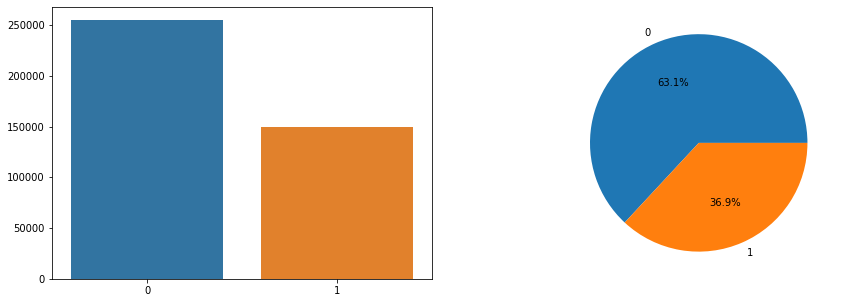

In [13]:
# output distribution (whether pair similar or not)
# 1-non duplicate questions; 0-duplicate

out=df["is_duplicate"]
duplicate, freq=np.unique(out, return_counts=True)

_,ax=plt.subplots(1,2, figsize=(15,5))
ax=ax.ravel()

sns.barplot(duplicate, freq, ax=ax[0])

ax[1].pie(freq, labels=duplicate, autopct='%1.1f%%' )
plt.show()

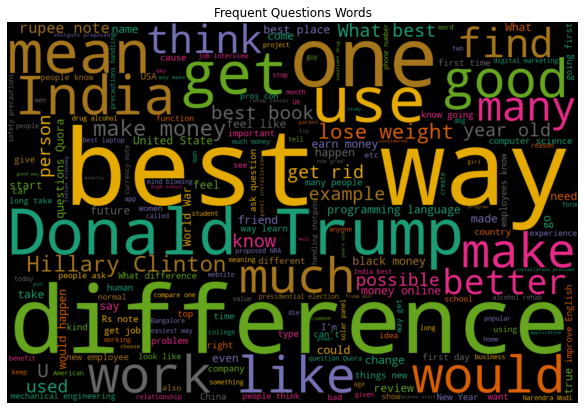

In [14]:
# display frequent words fo both 0/1 cases in text data

def visualize_wordcloud(df, title):
  q1=df["question1"]
  q2=df["question2"]
  data=q1.append(q2).dropna()
  data =" ".join([text.strip() for text in data ] )

  stopword_ll = set(stopwords.words("english"))

  plt.figure(figsize=(15,7))
  wc = WordCloud(width=1200, height=800, max_words=200, stopwords=stopword_ll, colormap="Dark2").generate(data)
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title(title)
  plt.show() 


visualize_wordcloud(df, "Frequent Questions Words")

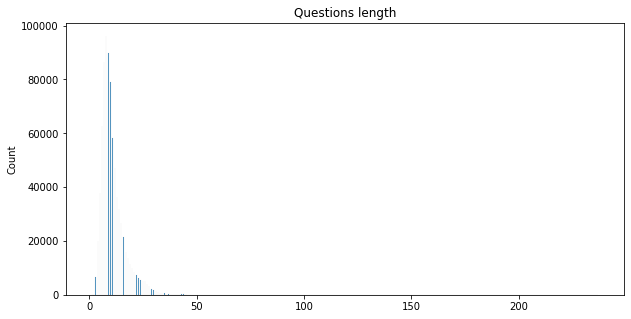

In [15]:
# length of each question in no of words

def questions_text_length(df):
  total_pairs=df.shape[0]

  q1=df["question1"]
  q2=df["question2"]
  questions=q1.append(q2).dropna()

  L=[]
  for qs in questions:
    n=len(qs.strip().split())
    L.append(n)

  plt.figure(figsize=(10,5))
  plt.title("Questions length")
  sns.histplot(L); plt.show()


questions_text_length(df)

# Data Preparation

## prepare corpus

In [16]:
# processing text to cleaned data

def clean_text(text_orig):
  text2=text_orig.lower()

  text2=re.sub("[!:;&=\?\[\]\^\|\\,`~{}_/\(\)\"]", " ", text2)  # "text:" -> "text"
  text2=re.sub("#[a-zA-Z]*[0-9]+[a-zA-Z]*", " ", text2)         # #1256 -> ""
  text2=re.sub("[a-zA-Z0-9]*@[a-zA-Z0-9]*", " ", text2)         # acc@mail.com -> "" ; (mail id)
  text2=re.sub("[a-zA-Z0-9]*\+[a-zA-Z0-9]*", " ", text2)        # #1256 -> ""
  text2=re.sub("<[ ]*/?[ ]*[a-zA-Z]*[ ]*/?[ ]*>", " ", text2)   # <br/> -> ""
  text2=re.sub("[<>]", " ", text2)                              # "<<abc>>" -> "text"
  text2=re.sub("\*", " ", text2)                                # "beta***" -> "beta"
  text2=re.sub("#", "", text2)                                  # "sh#" -> "sh"
  text2=re.sub("\-", "", text2)                                 # "un-clear" -> "unclear"
  text2=re.sub("\.", "", text2)                                 # "Dr."" -> "Dr"
  text2=text2.replace("\\", " ")                                # "\x01"" -> "x01"

  text2=re.sub("\$[0-9]+[a-zA-Z]*", " ", text2)                 # $1256 -> ""   ; (money)
  text2=re.sub("\$", " ", text2)                                # "$" -> ""

  text2=re.sub("[0-9]*%", " ", text2)                           # 85% -> ""   ; 
  text2=re.sub("%", " ", text2)                                 # "%" -> ""

  text2=re.sub("n't", " not", text2)                            # wasn't -> was not
  text2=re.sub("'t", " not", text2)                             # have't -> spell mistake
  text2=re.sub("'[ ]*am( |$)", " ", text2)                      # 'am ' am -> ""
  text2=re.sub("'[a-zA-Z0-9]([ ]+|$)", " ", text2)              # '[a-zA-Z] -> 0 ; ('s)
  text2=re.sub("'[a-zA-Z0-9][a-zA-Z0-9]([ ]+|$)", " ", text2)   # '[a-zA-Z][a-zA-Z] -> 0 ; ('ve)
  text2=re.sub("'", " ", text2)                                 # "beta'''" -> "beta"

  text2=re.sub(r'[^\x00-\x7F]+',' ', text2)                     # remove non-ascii characters
  text2=re.sub(r'[^\w ]', '', text2)                            # remove non-words ; \x01 \x08

  text2=re.sub(r"(^[a-zA-Z] )|( [a-zA-Z]$)|(\b[a-zA-Z]\b)", " ", text2)       # I -> ""   
  text2=re.sub("([ ]*|^)[0-9]+([ ]*|^)", " ", text2)            # 5845 -> ""   

  text2=text2.strip()

  return text2


# split line text into tokens

def tokenise_text(text):
  return word_tokenize(text)


In [17]:
# complete line text pre-processing

def preprocess_text(text):
  text=clean_text(text)
  text=tokenise_text(text)
  text=' '.join(text)

  return text


In [18]:
# return pre-processed dataframe from raw dataframe

def preprocess_corpus(df_orig):
  df=df_orig.copy()

  Q1=[]
  Q2=[]
  Y=[]

  for _, row in tqdm(df.iterrows()):   
    try:
      q1=row['question1']
      q2=row['question2']
      duplicate=row['is_duplicate']

      q1_preprocess=preprocess_text(q1)
      q2_preprocess=preprocess_text(q2)

      Q1.append(q1_preprocess)
      Q2.append(q2_preprocess)
      Y.append(duplicate)

    except:
      pass

  df_preprocessed=pd.DataFrame( {"question1":Q1, "question2":Q2, "is_duplicate":Y  } )

  del Q1, Q2, Y

  return df_preprocessed


In [19]:
df_processed=preprocess_corpus(df)

0it [00:00, ?it/s]

## vectorization

In [20]:
# function to create word to index map and vice versa.
# the corpus here is the preprocessed dataframe

def create_corpus_word_index_map(df):
  question=df["question1"]
  question=question.append( df["question2"] )

  word_ll=set()
  word_2_index={}
  index_2_word={}

  for _,line in tqdm(question.items()):
    w_ll=word_tokenize(line)
    for word in w_ll:
      word_ll.add(word)

  for index,word in enumerate(word_ll):
    word_2_index[word]=index
    index_2_word[index]=word

  return word_2_index, index_2_word


In [21]:
word_2_index, index_2_word = create_corpus_word_index_map(df_processed)

0it [00:00, ?it/s]

In [22]:
# get word2vec embedding for each word in corpus

def get_word_embedding(embed_model_file, embedding_dim, word_2_index):
  word_2_vec_model = gensim.models.KeyedVectors.load_word2vec_format(embed_model_file, binary = True)

  word_ll=word_2_vec_model.wv.index2word
  vec_ll=word_2_vec_model.wv.syn0

  pretrained_model_map={}
  for word,embed_value in tqdm(zip(word_ll, vec_ll)):
    pretrained_model_map[word]=embed_value

  embeddings = np.random.randn( len(word_2_index), embedding_dim).astype('float32')

  for word, index in tqdm(word_2_index.items()):
    if word in pretrained_model_map:
      embeddings[index]=pretrained_model_map[word]

  del pretrained_model_map

  return embeddings


In [23]:
embedding_dim=300
embed_model_file="/content/GoogleNews-vectors-negative300.bin.gz"

embeddings = get_word_embedding(embed_model_file, embedding_dim, word_2_index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  import sys


0it [00:00, ?it/s]

  0%|          | 0/87322 [00:00<?, ?it/s]

In [24]:
# create final processed data for model

def prepare_data(df, word_length, word_2_index):
  N=df.shape[0]
  X1=np.zeros( (N, word_length ), dtype=int)
  X2=np.zeros( (N, word_length ), dtype=int)
  Y=df["is_duplicate"].to_numpy()

  for index, row in tqdm(df.iterrows()):
    line1=row["question1"]
    line2=row["question2"]

    i=0
    vec=np.zeros(word_length, dtype=int)
    for word in word_tokenize(line1):
      if word in word_2_index:
        ind=word_2_index[word]
        vec[i]=ind
        i+=1
        if i>=word_length:
          break           
    X1[index,:]=vec

    i=0
    vec=np.zeros(word_length, dtype=int)
    for word in word_tokenize(line2):
      if word in word_2_index:
        ind=word_2_index[word]
        vec[i]=ind
        i+=1
        if i>=word_length:
          break          
    X2[index,:]=vec

  return (X1, X2, Y)


In [25]:
word_length=40

X1, X2, Y1=prepare_data(df_processed, word_length, word_2_index)

0it [00:00, ?it/s]

## train-test split

In [26]:
# train-test split

N=X1.shape[0]
N2=int(N*0.80)

X1_train=X1[:N2]
X2_train=X2[:N2]
Y1_train=Y1[:N2]

X1_test=X1[N2:]
X2_test=X2[N2:]
Y1_test=Y1[N2:]

In [27]:
X1_train.shape, X2_train.shape, Y1_train.shape, X1_test.shape, X2_test.shape, Y1_test.shape

((323429, 40), (323429, 40), (323429,), (80858, 40), (80858, 40), (80858,))

# Model

In [40]:
def base_model(word_length, embeddings):
  vocabulary_size, embedding_dim = embeddings.shape

  inp=Input(word_length,)
  x=inp
  x=Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, 
              weights=[embeddings], input_length=word_length, trainable=False)(x)
  
  # x=Bidirectional( LSTM(word_length, return_sequences=True) )(x)
  # x=BatchNormalization()(x)
  
  x=Bidirectional( GRU(word_length, return_sequences=False) )(x)

  model=Model(inp, x)
  return model


def siamese_model(word_length, embeddings):
  core_model=base_model(word_length, embeddings)

  inp1=Input(word_length, )
  inp2=Input(word_length, )  

  vec1=core_model(inp1)
  vec2=core_model(inp2)  

  vec=concatenate( [vec1, vec2] )

  x=Dense(1, activation="sigmoid")(vec)

  model= Model([inp1, inp2], x)
  return model


In [41]:
K.clear_session()
model=siamese_model(word_length, embeddings)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 model (Functional)             (None, 80)           26278680    ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 160)          0           ['model[0][0]',            

# Train

In [42]:
loss="binary_crossentropy"

model.compile(optimizer=Adam(learning_rate=1E-3), loss=loss, metrics=["accuracy"])

In [43]:
epochs=10
batch=256

history=model.fit([X1_train, X2_train], 
          Y1_train,
          epochs=epochs,
          validation_data=( [X1_test, X2_test], Y1_test),
          batch_size=batch)

Epoch 1/10
1264/1264 [==============================] - 30s 18ms/step - loss: 0.5683 - accuracy: 0.7080 - val_loss: 0.5622 - val_accuracy: 0.7081
Epoch 2/10
1264/1264 [==============================] - 22s 17ms/step - loss: 0.5291 - accuracy: 0.7375 - val_loss: 0.5161 - val_accuracy: 0.7481
Epoch 3/10
1264/1264 [==============================] - 22s 17ms/step - loss: 0.5071 - accuracy: 0.7512 - val_loss: 0.5097 - val_accuracy: 0.7522
Epoch 4/10
1264/1264 [==============================] - 22s 17ms/step - loss: 0.4907 - accuracy: 0.7620 - val_loss: 0.5109 - val_accuracy: 0.7538
Epoch 5/10
1264/1264 [==============================] - 22s 17ms/step - loss: 0.4761 - accuracy: 0.7708 - val_loss: 0.4985 - val_accuracy: 0.7604
Epoch 6/10
1264/1264 [==============================] - 22s 17ms/step - loss: 0.4638 - accuracy: 0.7779 - val_loss: 0.5021 - val_accuracy: 0.7582
Epoch 7/10
1264/1264 [==============================] - 22s 17ms/step - loss: 0.4524 - accuracy: 0.7842 - val_loss: 0.4951 -

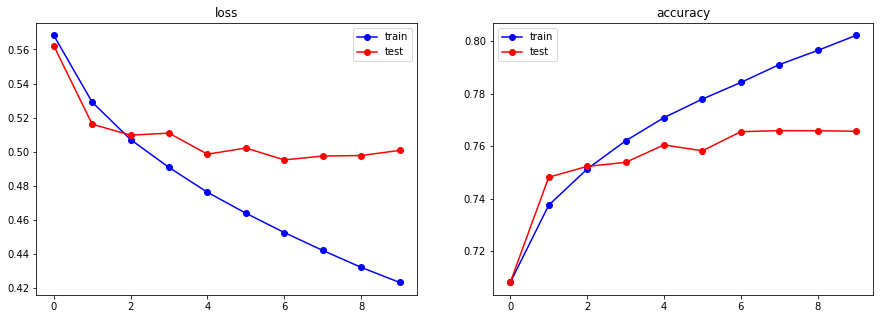

In [47]:
loss=history.history["loss"]
acc=history.history["accuracy"]
val_loss=history.history["val_loss"]
val_acc=history.history["val_accuracy"]

_, ax=plt.subplots(1,2,figsize=(15,5))
ax=ax.ravel()

ax[0].set_title("loss")
ax[0].plot(loss, "-bo")
ax[0].plot(val_loss, "-ro")
ax[0].legend(["train", "test"])

ax[1].set_title("accuracy")
ax[1].plot(acc, "-bo")
ax[1].plot(val_acc, "-ro")
ax[1].legend(["train", "test"])

plt.show()

# Evaluate

In [45]:
from sklearn.metrics import classification_report

pred=model.predict([X1_test, X2_test])
threshold=0.5
pred[pred>=threshold]=1
pred[pred!=1]=0

In [46]:
print(classification_report(Y1_test, pred))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82     51771
           1       0.68      0.65      0.66     29087

    accuracy                           0.77     80858
   macro avg       0.75      0.74      0.74     80858
weighted avg       0.76      0.77      0.76     80858



Text(33.0, 0.5, 'Actual')

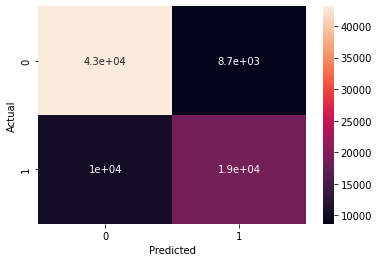

In [48]:
from sklearn.metrics import  confusion_matrix

cm=confusion_matrix(Y1_test, pred)
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')